In [1]:
import os
import sys
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from platypus import Problem, EpsNSGAII, Real, ProcessPoolEvaluator
import csv
import logging
from itertools import chain

logging.basicConfig(level=logging.INFO)
plt.rcParams["figure.figsize"] = [12, 8]
# sys.path.append('..')

In [2]:
sys.path.append(os.path.abspath(".."))
from susquehanna_model import SusquehannaModel
import rbf_functions

In [3]:
rbfs = [
    rbf_functions.squared_exponential_rbf,
    rbf_functions.original_rbf,
    rbf_functions.inverse_quadratic_rbf,
    rbf_functions.inverse_multiquadric_rbf,
    rbf_functions.exponential_rbf,
    rbf_functions.matern32_rbf,
    rbf_functions.matern52_rbf,
]

reference_sets = {}
for entry in rbfs:
    name = entry.__name__
    reference_sets[name] = pd.read_csv(
        os.path.join("./refsets", f"{name}_refset_with_variables.csv")
    )


for filename in os.listdir("../data1999"):
    if filename.startswith("w"):
        globals()[f"{filename[:-4]}"] = np.loadtxt(f"../data1999/{filename}")
    elif filename == "salinity_min_flow_req.txt":
        globals()[f"{filename[:-4]}"] = np.loadtxt(
           os.path.join("../data1999", filename)
        )
    elif filename == "min_flow_req.txt":
        globals()[f"{filename[:-4]}"] = np.loadtxt(
            os.path.join("../data1999", filename)
        )

In [4]:
entry = rbfs[0]
reference_set = reference_sets[entry.__name__]

# setup the RBF network
n_inputs = 2  # (time, storage of Conowingo)
n_outputs = 4  # Atomic, Baltimore, Chester, Downstream:- (hydropower, environmental)
n_rbfs = n_inputs + 2
rbf = rbf_functions.RBF(n_rbfs, n_inputs, n_outputs, rbf_function=entry)

# Initialize model
nobjs = 6
n_years = 1
susquehanna_river = SusquehannaModel(
    108.5, 505.0, 5, n_years, rbf
)  # l0, l0_MR, d0, years
# l0 = start level cono, l0_MR = start level muddy run, d0 = startday > friday = 5

susquehanna_river.set_log(True)

output = []
# iterate over solutions
for _, row in reference_set.iloc[0:10, 0:32].iterrows():
    output.append(susquehanna_river.evaluate(row))

In [5]:
level_CO, level_MR, ratom, rbalt, rches, renv = susquehanna_river.get_log()

# quick check of decision variables

It is notable how the poorly performing RBFs struggle with the more or less flat demand profiles. Is this due to artificial limits on the decision variables?

We can quickly visualize othe decision variables using a parallel coordinate system

/var/folders/bs/pq8dwg2x1292xl2v3fdv89nxg6tx1q/T/ipykernel_81954/2617403275.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')
/var/folders/bs/pq8dwg2x1292xl2v3fdv89nxg6tx1q/T/ipykernel_81954/2617403275.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.0)


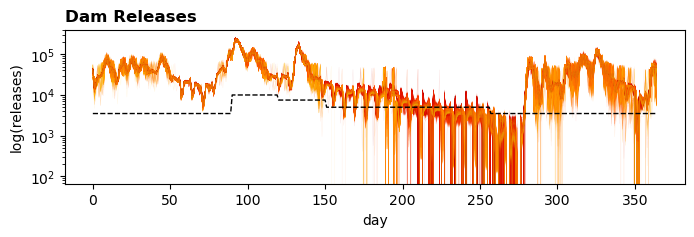

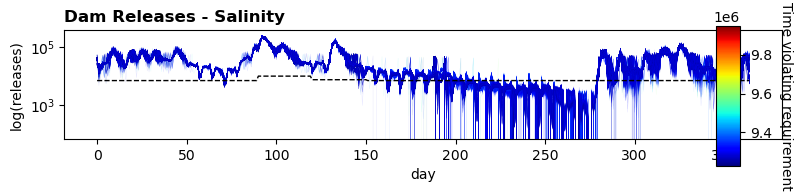

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

alpha = 0.1
lw = 0.3

# Specify the first RBF entry to use
entry = rbfs[0]
name = entry.__name__
reference_set = reference_sets[name]

numberOfRBF = 6  # numberOfInput + 2
n_inputs = 2  # (time, storage of Conowingo)
n_outputs = 4  # Atomic, Baltimore, Chester, Downstream:- (hydropower, environmental)
n_rbfs = n_inputs + 2
rbf = rbf_functions.RBF(n_rbfs, n_inputs, n_outputs, rbf_function=entry)

# Initialize model
nobjs = 6
n_years = 1
susquehanna_river = SusquehannaModel(
    108.5, 505.0, 5, n_years, rbf
)  # l0, l0_MR, d0, years
susquehanna_river.set_log(True)

# Evaluate the model for each row in the reference set
for _, row in reference_set.iloc[:, 0:32].iterrows():
    susquehanna_river.evaluate(row)

# Retrieve outputs
level_CO, level_MR, ratom, rbalt, rches, renv = susquehanna_river.get_log()

# Calculate areas between min_flow_req and each release in renv
areas_ferc = []
for release in renv:
    area = np.trapz(np.abs(min_flow_req - release), dx=1)
    areas_ferc.append(area)

# Calculate areas between salinity_min_flow_req and each release in renv
areas_salinity = []
for release in renv:
    area = np.trapz(np.abs(salinity_min_flow_req - release), dx=1)
    areas_salinity.append(area)

# Combine areas for normalization
all_areas = areas_ferc + areas_salinity
norm = Normalize(vmin=min(all_areas), vmax=max(all_areas))
cmap = plt.cm.get_cmap('jet')

# Plotting FERC minimum flow
fig, ax = plt.subplots(figsize=(8, 2))

for release, area in zip(renv, areas_ferc):
    color = cmap(norm(area))
    ax.plot(release, c=color, linewidth=lw, alpha=alpha)

ax.plot(min_flow_req, "black", ls="--", linewidth=1)
ax.set_ylabel("log(releases)")
ax.set_title("Dam Releases", loc="left", weight="bold")
ax.set_yscale("log")
ax.set_xlabel("day")

# Plotting Salinity minimum flow
fig, ax = plt.subplots(figsize=(8, 2))

for release, area in zip(renv, areas_salinity):
    color = cmap(norm(area))
    ax.plot(release, c=color, linewidth=lw, alpha=alpha)

ax.plot(salinity_min_flow_req, "black", ls="--", linewidth=1)
ax.set_ylabel("log(releases)")
ax.set_title("Dam Releases - Salinity", loc="left", weight="bold")
ax.set_yscale("log")
ax.set_xlabel("day")

# Create a single colorbar for both plots
fig.subplots_adjust(right=0.85)
#cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Time violating requirement', rotation=270, labelpad=15)

fig.tight_layout(pad=1.0)
plt.savefig(f"figs/Combined_Min_releases.svg")
#plt.show()


/var/folders/bs/pq8dwg2x1292xl2v3fdv89nxg6tx1q/T/ipykernel_81954/963854441.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')  # Choose a colormap


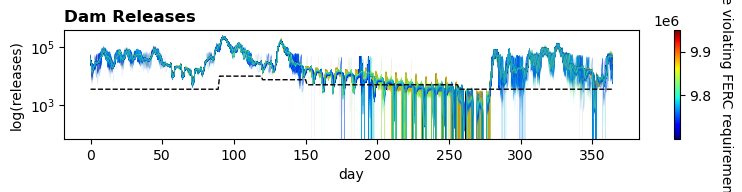

In [7]:
#FERC minimum flow plot for frequency of violation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

alpha = 0.1
lw = 0.3

# Specify the first RBF entry to use
entry = rbfs[0]
name = entry.__name__
reference_set = reference_sets[name]

numberOfRBF = 6  # numberOfInput + 2
n_inputs = 2  # (time, storage of Conowingo)
n_outputs = 4  # Atomic, Baltimore, Chester, Downstream:- (hydropower, environmental)
n_rbfs = n_inputs + 2
rbf = rbf_functions.RBF(n_rbfs, n_inputs, n_outputs, rbf_function=entry)

# Initialize model
nobjs = 6
n_years = 1
susquehanna_river = SusquehannaModel(
    108.5, 505.0, 5, n_years, rbf
)  # l0, l0_MR, d0, years
susquehanna_river.set_log(True)

# Evaluate the model for each row in the reference set
for _, row in reference_set.iloc[:, 0:32].iterrows():
    susquehanna_river.evaluate(row)

# Retrieve outputs
level_CO, level_MR, ratom, rbalt, rches, renv = susquehanna_river.get_log()

# Calculate areas between min_flow_req and each release in renv
areas = []
for release in renv:
    area = np.trapz(np.abs(min_flow_req - release), dx=1)
    areas.append(area)

# Define colormap and normalize areas
cmap = plt.cm.get_cmap('jet')  # Choose a colormap
norm = Normalize(vmin=min(areas), vmax=max(areas))  # Normalize areas

# Plotting
fig, ax = plt.subplots(figsize=(8, 2))

for release, area in zip(renv, areas):
    color = cmap(norm(area))  # Determine color based on normalized area
    ax.plot(release, c=color, linewidth=lw, alpha=alpha)

ax.plot(min_flow_req, "black", ls="--", linewidth=1)  # Plotting min_flow_req

# Create a ScalarMappable for colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array as we'll not plot anything for mappable
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Time violating FERC requirement', rotation=270, labelpad=15)

ax.set_ylabel("log(releases)")
ax.set_title("Dam Releases", loc="left", weight="bold")
ax.set_yscale("log")
ax.set_xlabel("day")

fig.tight_layout(pad=1.0)
plt.savefig(f"figs/Min_releases.svg")
plt.show()

/var/folders/bs/pq8dwg2x1292xl2v3fdv89nxg6tx1q/T/ipykernel_81954/2362249492.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


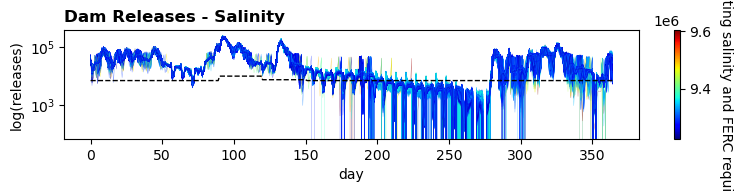

In [8]:
#salinity flow requirement

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

alpha = 0.5
lw = 0.3

# Specify the first RBF entry to use
entry = rbfs[0]
name = entry.__name__
reference_set = reference_sets[name]

numberOfRBF = 6  # numberOfInput + 2
n_inputs = 2  # (time, storage of Conowingo)
n_outputs = 4  # Atomic, Baltimore, Chester, Downstream:- (hydropower, environmental)
n_rbfs = n_inputs + 2
rbf = rbf_functions.RBF(n_rbfs, n_inputs, n_outputs, rbf_function=entry)

# Initialize model
nobjs = 6
n_years = 1
susquehanna_river = SusquehannaModel(
    108.5, 505.0, 5, n_years, rbf
)  # l0, l0_MR, d0, years
susquehanna_river.set_log(True)

# Evaluate the model for each row in the reference set
for _, row in reference_set.iloc[:, 0:32].iterrows():
    susquehanna_river.evaluate(row)

# Retrieve outputs
level_CO, level_MR, ratom, rbalt, rches, renv = susquehanna_river.get_log()

# Calculate areas between salinity_min_flow_req and each release in renv
areas = []
for release in renv:
    area = np.trapz(np.abs(salinity_min_flow_req - release), dx=1)
    areas.append(area)

# Define colormap and normalize areas
cmap = plt.cm.get_cmap('jet')  
norm = Normalize(vmin=min(areas), vmax=max(areas))  # Normalize areas

# Plotting
fig, ax = plt.subplots(figsize=(8, 2))

for release, area in zip(renv, areas):
    color = cmap(norm(area))  # Determine color based on normalized area
    ax.plot(release, c=color, linewidth=lw, alpha=alpha)

ax.plot(salinity_min_flow_req, "black", ls="--", linewidth=1)  # Plotting salinity_min_flow_req

# Create a colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array as we'll not plot anything for mappable
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Time violating salinity and FERC requirement', rotation=270, labelpad=15)

ax.set_ylabel("log(releases)")
ax.set_title("Dam Releases - Salinity", loc="left", weight="bold")
ax.set_yscale("log")
ax.set_xlabel("day")

fig.tight_layout(pad=1.0)
plt.savefig(f"figs/Min_salinity_releases.svg")
plt.show()